In [1]:
# Imports
import numpy as np
import numpy.ma as ma
import os
from matplotlib import pyplot as plt
import h5py as h5
from PyXRIM.Corrections import Corrector
from PyXRIM.misc import  bin_ndarray
from functions import *
from decompFunctions import *
%matplotlib notebook

In [2]:
#Inputs
fname = 'D:\Libraries\Documents\Materials Informatics\LiCoO2_Al2O3_20160330.hdf5'
#datasets = ['S026','S027','S028'] # name of raw dataset
datasets = ['S026'] # name of raw dataset
procRefName = 'bkg_corrected' # reference name to append to rawData

In [3]:
# open h5file
f = h5.File(fname, mode='r') 
# Always open in read mode 'r'.
# Until you're ready to write into the file. This is especially true if your OS is not Unix-based like Windows.
rawg = f['20160330/Raw']
procg = f['20160330/Process']
meta = f['20160330/Meta']

In [4]:
#roi1x=slice(250,640)
#roi1y=slice(510,900)  #original 1024

roi1x=slice(0,1024)
roi1y=slice(0,1024)  #original 1024


i = 0;
for name in datasets:
    rawDset = rawg[name]
    procDset = f[rawDset.attrs['bkg_corrected']]   

    if i == 0:
        #data = procDset[:,:,:]
        data = procDset[:,roi1x,roi1y]
        datalog = procDset[:,roi1x,roi1y]+10
    
        twotheta = rawDset.attrs['delta']
        
        i = 1
    else:
        #data = np.vstack([data, procDset[:,:,:]])
        data = np.vstack([data, procDset[:,roi1x,roi1y]])
        datalog = np.vstack([datalog, procDset[:,roi1x,roi1y]+10])

        twotheta = np.hstack([twotheta,rawDset.attrs['delta']])
        

In [5]:
##Insert DELETE CODE
if datasets == ['S026']:
    data_new = data[1:,:,:]
    datalog_new = datalog[1:,:,:]
    twotheta_new = twotheta[1:]
else:
    data_new = data
    datalog_new = datalog
    twotheta_new = twotheta

print data_new.shape
print datalog_new.shape
print twotheta_new.shape

(40L, 1024L, 1024L)
(40L, 1024L, 1024L)
(40L,)


In [6]:
#Mask Data
mask = np.zeros(data_new.shape)
for x in range(0,1024):
    for y in range(0,1024):
        l1L = -0.0004*x*x - 0.2052*x+445.45
        l2L = 0.0017*x*x + 0.1998*x + 584
        
        l1U = -0.0018*x*x - 0.038*x + 221
        l2U = 0.0006*x*x+0.27*x+328.58
        
        if ((y > l1U ) and (y < l1L)) or ((y > l2U) and (y < l2L)) or (y>900) or (x>1000) or (x<300) or (y<100):
            mask[:,y,x] = 1
datamasked = ma.masked_array(data_new,mask)

<IPython.core.display.Javascript object>


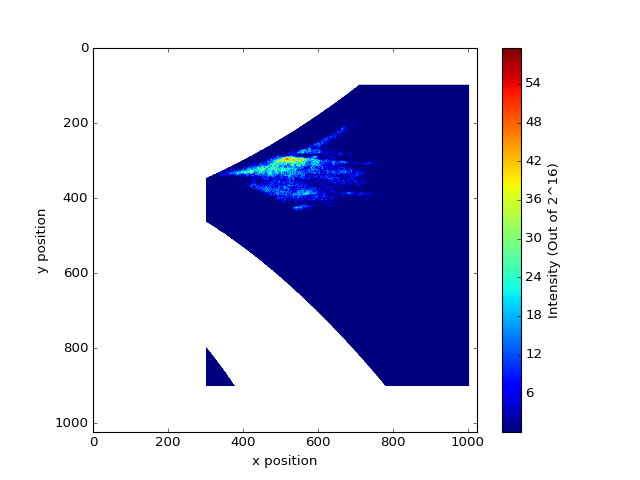

In [7]:
fig,ax = plt.subplots()
cax = ax.imshow(datamasked[10,:,:])
cbar = fig.colorbar(cax)
cbar.set_label('Intensity (Out of 2^16)')
ax.set_xlabel('x position')
ax.set_ylabel('y position')

<IPython.core.display.Javascript object>


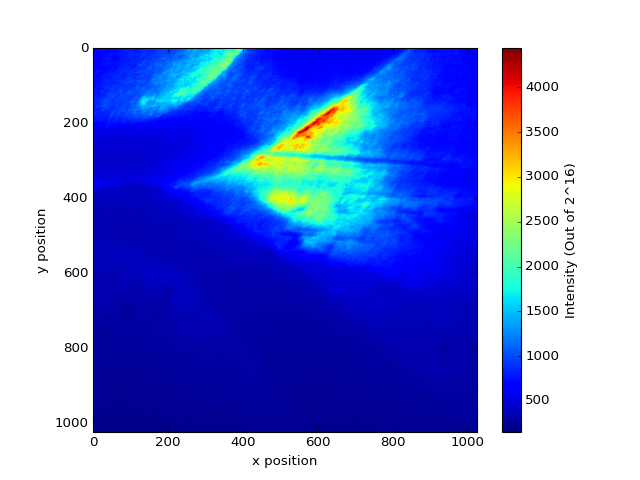

In [8]:
fig,ax = plt.subplots()
cax = ax.imshow(data_new[30,:,:])
cbar = fig.colorbar(cax)
cbar.set_label('Intensity (Out of 2^16)')
ax.set_xlabel('x position')
ax.set_ylabel('y position')

In [9]:
# PCA
xvals= twotheta_new
# You should do one PCA with logscaling = True and another with logscaling = False to compare.

mask_prep = preping(mask, logscaling = False, feature_scaling=False, feature_range=(0.1,1))
data_prep = preping(data_new, logscaling = False, feature_scaling=False, feature_range=(0.1,1))
datalog_prep = preping(datalog_new, logscaling = True, feature_scaling=False, feature_range=(0.1,1))


<IPython.core.display.Javascript object>


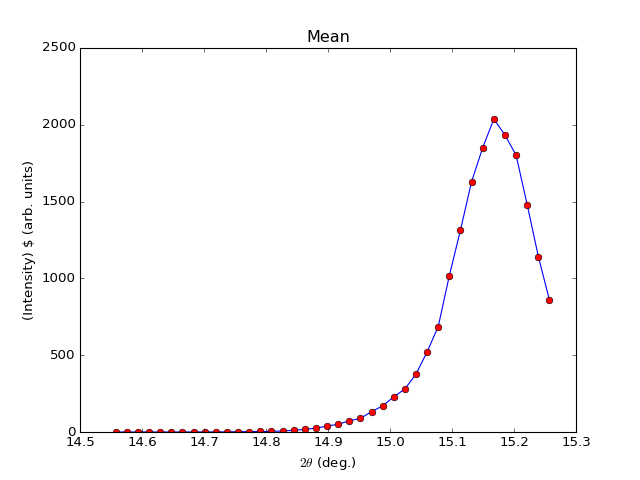

<IPython.core.display.Javascript object>


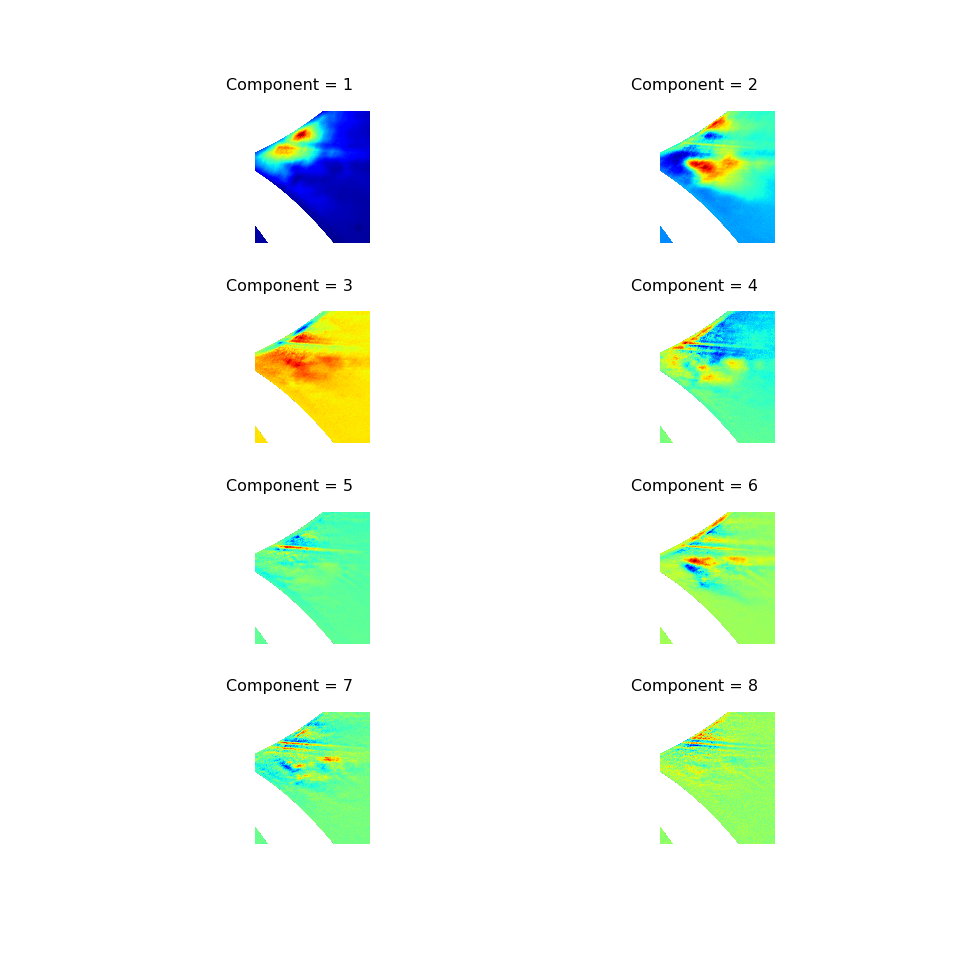

<IPython.core.display.Javascript object>


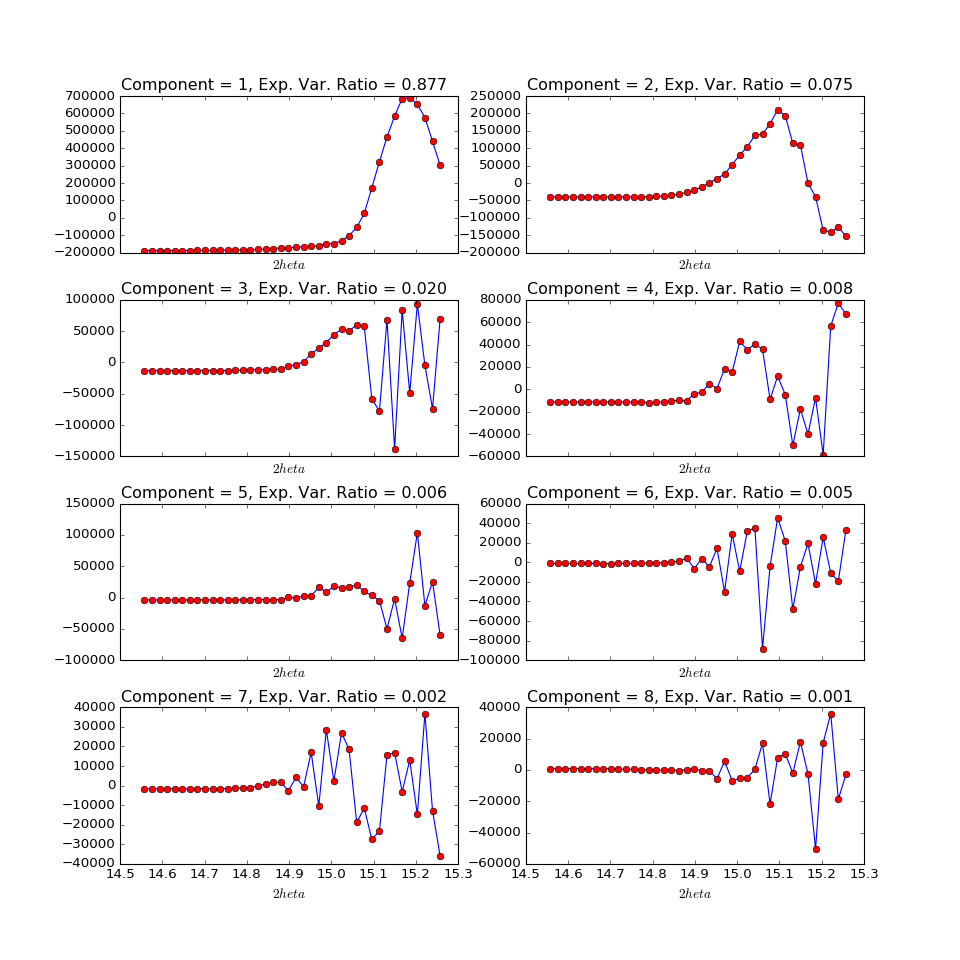

In [10]:
# set the number of principal components we want PCA to use. Try multiple numbers.
n_comp = 8
r_comp = 8
#projec, eigenvec, var_ratio, pca = doPCA(data2, n_comp, xvals=xvals,xlabel='$2\theta$',cmap='rainbow')
projec, eigenvec, var_ratio, pca = doPCA_Mask(data_prep, n_comp, mask, xvals=xvals,xlabel='$2\theta$',
                                         cmap='rainbow',normalize = True, returnComponents = r_comp)


<IPython.core.display.Javascript object>


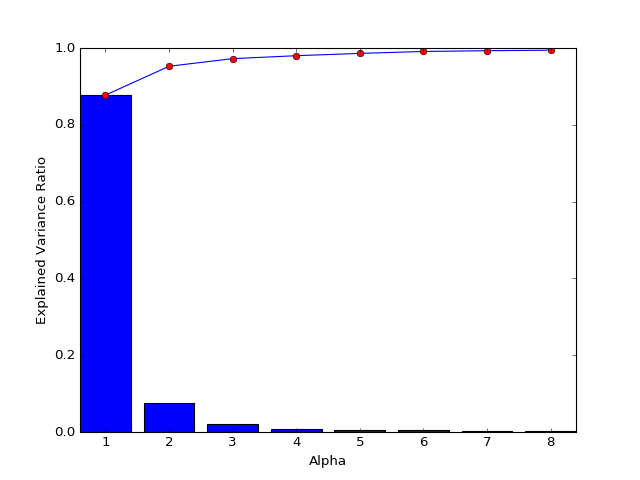

(0, 1)

In [11]:
v = var_ratio[0]
vSum = var_ratio[0]
for i in range(1,var_ratio.shape[0]):
    v = np.hstack([v,var_ratio[i]])
    vSum = np.hstack([vSum,np.sum(var_ratio[0:i+1])])
    
fig,ax = plt.subplots()
ax.bar(np.arange(1,var_ratio.shape[0]+1)-0.4,v)
ax.plot(np.arange(1,var_ratio.shape[0]+1),vSum,marker = 'o', markerfacecolor='r')
ax.set_xlabel('Alpha')
ax.set_xlim([0.6,var_ratio.shape[0]+0.4])
ax.set_ylabel('Explained Variance Ratio')
ax.set_ylim([0,1])

<IPython.core.display.Javascript object>


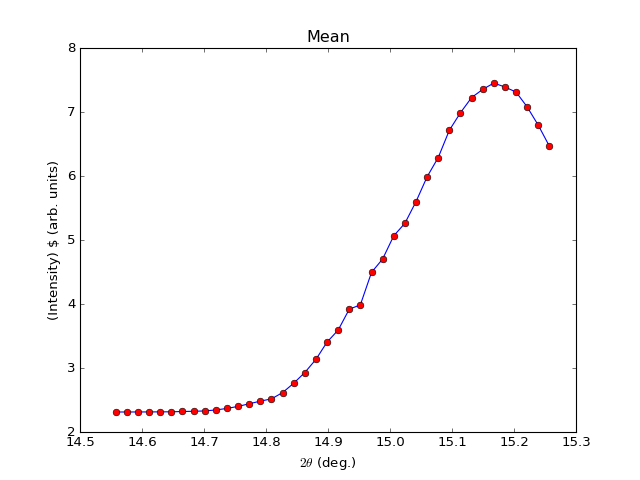

<IPython.core.display.Javascript object>


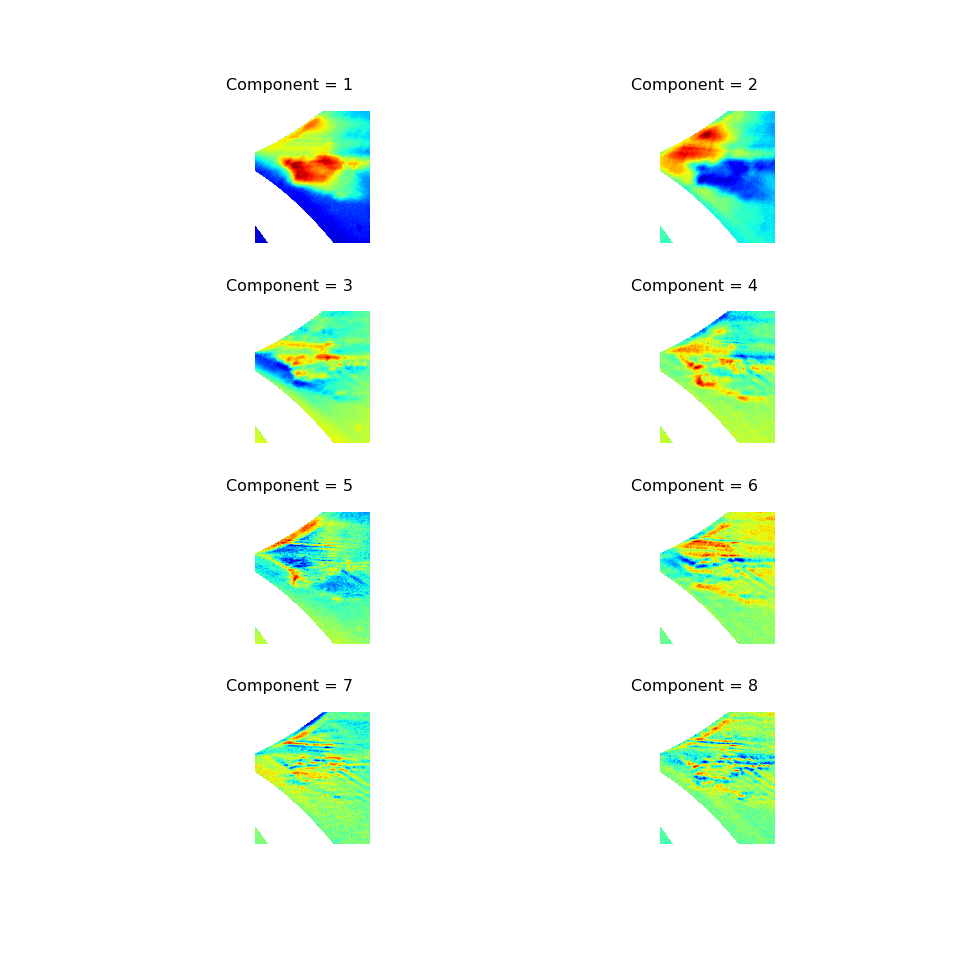

<IPython.core.display.Javascript object>


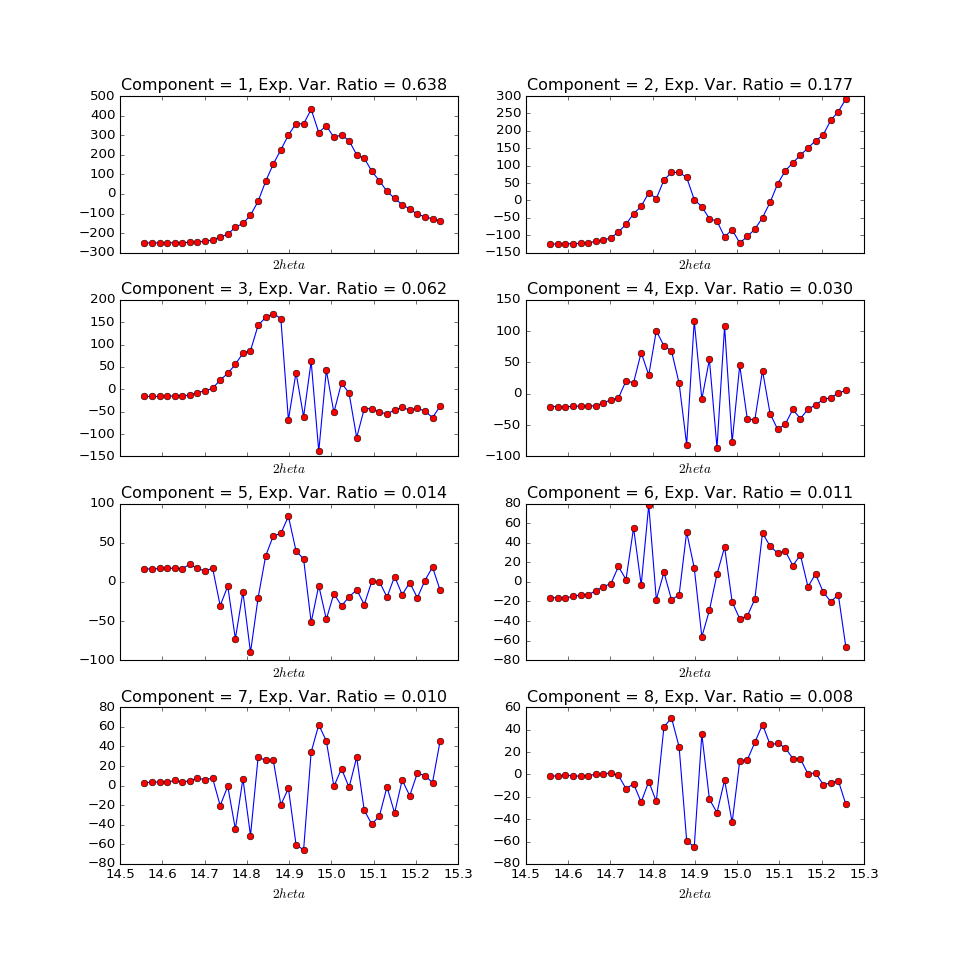

In [12]:
# set the number of principal components we want PCA to use. Try multiple numbers.
n_comp = 8
r_comp = 20
#projec, eigenvec, var_ratio, pca = doPCA(data2, n_comp, xvals=xvals,xlabel='$2\theta$',cmap='rainbow')
projec, eigenvec, var_ratio, pca = doPCA_Mask(datalog_prep, n_comp, mask, xvals=xvals,xlabel='$2\theta$',
                                         cmap='rainbow',normalize = True, returnComponents = r_comp)

In [13]:
print projec.shape

(20L, 1024L, 1024L)


<IPython.core.display.Javascript object>


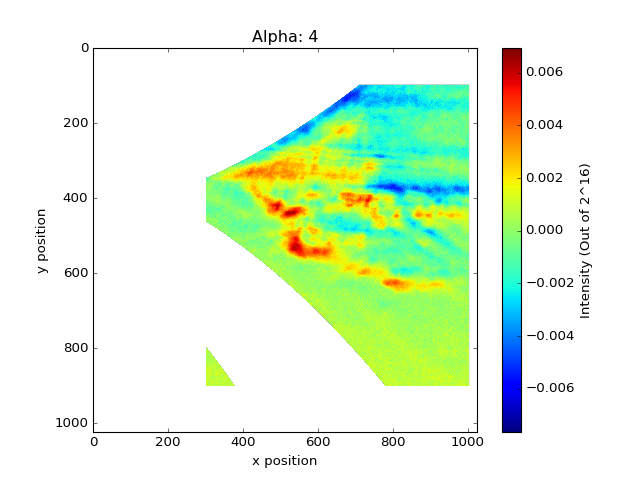

<IPython.core.display.Javascript object>


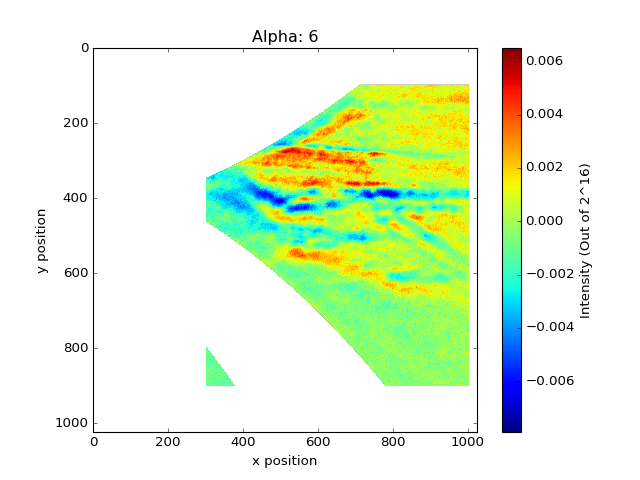

In [14]:
component = 4
fig,ax = plt.subplots()
cax = ax.imshow(ma.masked_array(projec[component-1,:,:],mask[0,:,:]))
cbar = fig.colorbar(cax)
cbar.set_label('Intensity (Out of 2^16)')
ax.set_title('Alpha: ' + str(component))
ax.set_xlabel('x position')
ax.set_ylabel('y position')

component = 6
fig,ax = plt.subplots()
cax = ax.imshow(ma.masked_array(projec[component-1,:,:],mask[0,:,:]))
cbar = fig.colorbar(cax)
cbar.set_label('Intensity (Out of 2^16)')
ax.set_title('Alpha: ' + str(component))
ax.set_xlabel('x position')
ax.set_ylabel('y position')

<IPython.core.display.Javascript object>


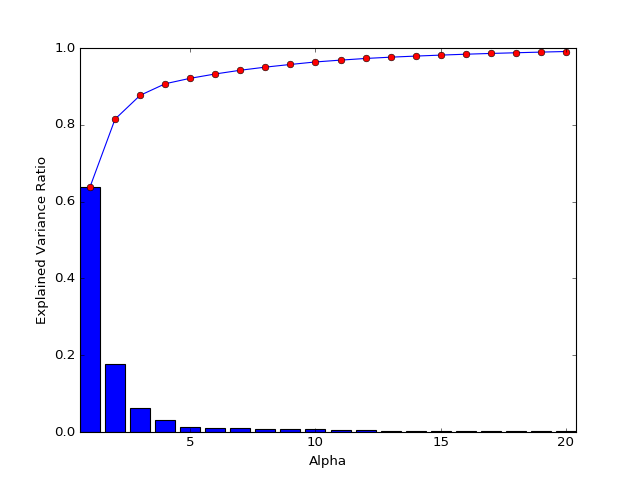

(0, 1)

In [15]:
v = var_ratio[0]
vSum = var_ratio[0]
for i in range(1,var_ratio.shape[0]):
    v = np.hstack([v,var_ratio[i]])
    vSum = np.hstack([vSum,np.sum(var_ratio[0:i+1])])
    
fig,ax = plt.subplots()
ax.bar(np.arange(1,var_ratio.shape[0]+1)-0.4,v)
ax.plot(np.arange(1,var_ratio.shape[0]+1),vSum,marker = 'o', markerfacecolor='r')
ax.set_xlabel('Alpha')
ax.set_xlim([0.6,var_ratio.shape[0]+0.4])
ax.set_ylabel('Explained Variance Ratio')
ax.set_ylim([0,1])

<IPython.core.display.Javascript object>


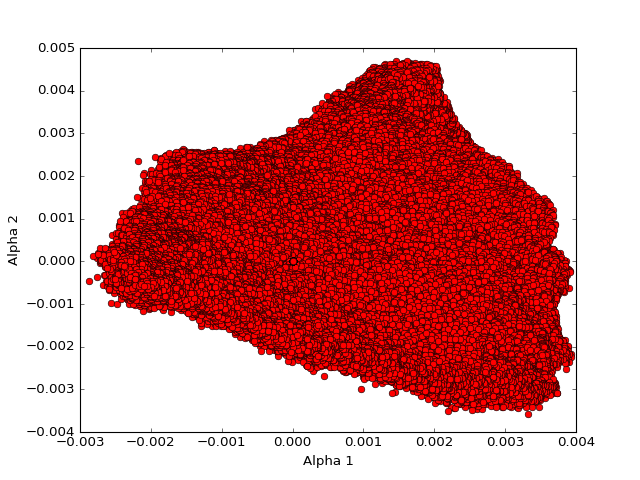

In [16]:
alphax = 1
alphay = 2

alpha = projec.reshape(20,-1)

fig,ax = plt.subplots()
ax.plot(alpha[alphax-1,:],alpha[alphay-1,:],'ro')
ax.set_xlabel('Alpha ' + str(alphax))
ax.set_ylabel('Alpha ' + str(alphay))